In [ ]:
#Titanic ML Kaggle Competition

By AJ Iglesias

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from collections import Counter

In [94]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

#Used for final results
Pass_ID = test_df['PassengerId']

In [95]:
#Check out if any outliers using Quartile Ranges
def check_outliers(df, n, features):
    outliers_lst = []
    
    for feat in features:
        #Q1 25% 
        Q1 = np.percentile(df[feat], 25)
        #Q3 75%
        Q3 = np.percentile(df[feat], 75)
        #Inner Quartile Range
        IQR = Q3 - Q1
        
        #Determining outlier
        outlier = 1.5 * IQR
        
        #Determine which cols have outliers
        outlier_lst_col = df[(df[feat] < Q1 - outlier) | (df[feat] > Q3 + outlier)].index
        
        #Append the columns
        outliers_lst.extend(outlier_lst_col)
        
    #Drop outliers in more than n present in data
    outliers_tot = Counter(outliers_lst)
    outliers = list(j for j, o in outliers_tot.items() if o > n)
    
    return outliers
        

In [96]:
confirm_outliers = check_outliers(train_df, 2, ['Age', 'Parch', 'SibSp', 'Fare'])
confirm_outliers
#Locate the columns to drop
train_df.loc[confirm_outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [97]:
#Drop the confirmed outliers
train_df = train_df.drop(confirm_outliers, axis = 0).reset_index(drop=True)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
877,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
879,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Combine the train and test set then perform some feature engineering plus analysis before prediction

In [98]:
#Get length for splitting once we are ready for modeling
train_len = len(train_df)

data = pd.concat(objs = [train_df, test_df], axis = 0, sort = False).reset_index(drop=True)
data.shape

(1299, 12)

<h1> Feature Engineering </h1>

<h3> Part 1) Families </h3>

In [99]:
#Create new feature Family Size
data['Family_Size'] = data['SibSp'] + data['Parch'] + 1
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [100]:
#Decipher between family sizes on board
data['Single'] = data['Family_Size'].map(lambda f: 1 if f == 1 else 0)

#Small Families
data['Small_Fam'] = data['Family_Size'].map(lambda f: 1 if f == 2 else 0)

#Medium Families
data['Medium_Fam'] = data['Family_Size'].map(lambda f: 1 if 3 <= f <= 4 else 0)

#Large Families
data['Large_Fam'] = data['Family_Size'].map(lambda f: 1 if f >= 5 else 0)

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Single,Small_Fam,Medium_Fam,Large_Fam
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,1,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,1,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,0,0,0


<h3> Part 2: Cabins </h3>

In [101]:
data['Cabin'].value_counts()

B57 B59 B63 B66    5
G6                 5
C78                4
D                  4
F33                4
                  ..
C70                1
A14                1
B37                1
E45                1
A5                 1
Name: Cabin, Length: 186, dtype: int64

In [102]:
#Extract the first letter of the cabin ID in order to get what cabin passenger's are in
data['Cabin'] = data['Cabin'].astype(str)
data['Cabin'] = data['Cabin'].str.replace(r'[0-9]', '', regex = True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Single,Small_Fam,Medium_Fam,Large_Fam
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,nan,S,2,0,1,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,2,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S,1,1,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,2,0,1,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,nan,S,1,1,0,0,0


In [103]:
data['Cabin'].value_counts()

nan        1007
C            80
B            48
D            44
E            40
A            22
F            14
C C           8
B B           8
G             5
B B B B       5
B B B         4
F G           4
F E           3
C C C         3
D D           2
E E           1
T             1
Name: Cabin, dtype: int64

In [104]:
data['Cabin'] = data['Cabin'].replace({'B B': 'B', 'C C': 'C', 'B B B B': 'B', 'F G': 'F', 'B B B': 'B', 'F E': 'F', 
                                  'C C C': 'C', 'D D': 'D', 'E E': 'E'}, regex = True)
data['Cabin'] = data['Cabin'].replace({'B B': 'B', 'C C': 'C'}, regex = True)
data['Cabin'].value_counts()

nan    1007
C        91
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: Cabin, dtype: int64

In [105]:
#Now we need to take care of the NaN's I will create a new cabin class for them named 'Z'
data['Cabin'] = data['Cabin'].replace('nan', 'Z')
data['Cabin'].value_counts()

Z    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [106]:
data = pd.get_dummies(data, columns = ['Cabin'], prefix = 'Cabin')

<h3> Part 3) Titles </h3>

In [107]:
#Let's make a new column based on the titles of the people on board
data['Title'] = [title.split(',')[1].split('.')[0] for title in data['Name']]
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,1,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0,0,0,0,0,0,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,1,0,0,0,0,0,0,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,1,Mr


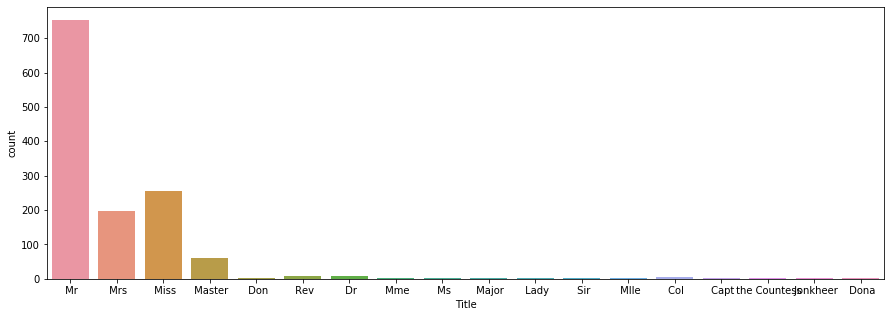

In [108]:
#Let's visualize the types of titles that are included in the dataset
titles = data['Title'].value_counts()
titles
#We can use count plot to visualize this and clearly see that several titles are rarely seen
fig, ax = plt.subplots(figsize = (15,5))
title_plot = sns.countplot(x = 'Title', data = data, ax = ax)

Alright nice so we have gotten rid of outliers and made a new column of Titles but now we need to consider very uncommon titles and convert them to numerical values

In [109]:
#Categorical to Numerical
data['Title'] = data['Title'].replace([' Major', ' the Countess', ' Sir', ' Lady', ' Don', ' Rev',
                                       ' Dr', ' Col', ' Capt', ' Jonkheer', 
                                       ' Dona', ' Countess'], 'Uncommon')
#Bug in code here
mapping = {' Master': 0, ' Miss': 1, ' Mrs': 1, ' Ms': 1, ' Mlle': 1, ' Mme': 1, 'Uncommon': 2, 'Uncommona': 2, ' Mr': 3}

data = data.applymap(lambda x: mapping.get(x) if x in mapping else x)
data['Title'] = data['Title'].astype(int)
data['Title'].value_counts()

3    753
1    457
0     60
2     29
Name: Title, dtype: int64

In [110]:
#Convert them to numerical
data = pd.get_dummies(data, columns = ['Title'], prefix = 'Title')

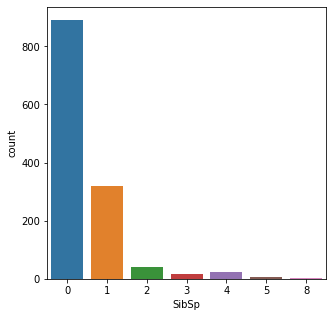

In [111]:
#Let's compare people with siblings or spouses and see the distribution.
#Clearly a lot more people are on board with either none or 1 spouse or sibling with them than multiple 
fig, ax = plt.subplots(figsize = (5,5))
fam_graph = sns.countplot(x = 'SibSp', data = data, ax = ax)

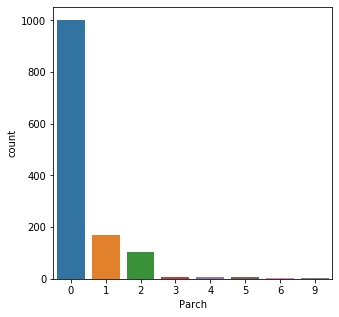

In [112]:
#And now parents and children on board as well
fig, ax = plt.subplots(figsize = (5,5))
par_child_graph = sns.countplot(x = 'Parch', data = data, ax = ax)

Okay majority of people on board were alone or with one significant other or family member

Let's check for null values before comparing survivability

In [113]:
data.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            256
SibSp            0
Parch            0
Ticket           0
Fare             1
Embarked         2
Family_Size      0
Single           0
Small_Fam        0
Medium_Fam       0
Large_Fam        0
Cabin_A          0
Cabin_B          0
Cabin_C          0
Cabin_D          0
Cabin_E          0
Cabin_F          0
Cabin_G          0
Cabin_T          0
Cabin_Z          0
Title_0          0
Title_1          0
Title_2          0
Title_3          0
dtype: int64

Replace the missing ages with the mean age of passenger's on board

In [114]:
#Try median after model is built to see which obtains higher accuracy
data['Age'] = data['Age'].fillna(data['Age'].mean())

#Confirm the code above will indeed compute and replace ages with average age on board
print(data['Age'].mean())

#Confirm nan values for age are replaced
data.isnull().sum()

29.903806327900284


PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Embarked         2
Family_Size      0
Single           0
Small_Fam        0
Medium_Fam       0
Large_Fam        0
Cabin_A          0
Cabin_B          0
Cabin_C          0
Cabin_D          0
Cabin_E          0
Cabin_F          0
Cabin_G          0
Cabin_T          0
Cabin_Z          0
Title_0          0
Title_1          0
Title_2          0
Title_3          0
dtype: int64

Now we need to replace Cabin and Embarked nans

So we notice that over 680/881 cabin values are missing, I believe replacing these with a mean, median or 0 value will skew our data when training the model so I am going to remove this column as a whole from the analysis

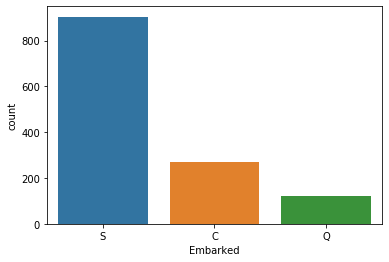

In [115]:
#Finally for embarked which designates which port they embarked from it can only three options
# S = Southampton, Q = Queenstown, C = Cherbourg
#Let's visualize that
port_graph = sns.countplot(x = 'Embarked', data = data)

In [116]:
#For purposes to confirm the replacing went to right value
data['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [117]:
#Replacing the 2 null values with 'Q'
data['Embarked'] = data['Embarked'].fillna('Q')

In [118]:
#We should see that the Queenstown port ('Q') has two additional members
data['Embarked'].value_counts()

S    904
C    270
Q    125
Name: Embarked, dtype: int64

In [119]:
#Convert to numerical 
data = pd.get_dummies(data, columns = ['Embarked'], prefix = 'Emb')

Cool so now we have no more null values in the training set

One more feature engineering issue to address, notice the sex of a person is indicated male and female right now let's change that to a binary classification. Let's make male = 0 and female = 1.

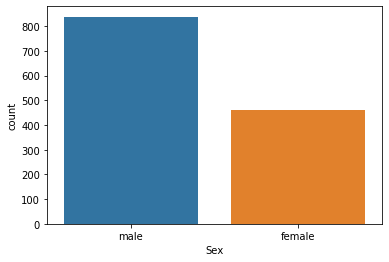

In [120]:
#First let's see the descrempancy of males and females on board
gender_plot = sns.countplot(x = 'Sex', data = data)

Roughly a 2 to 1 ratio between males and females on board. Interesting

In [121]:
#Lets make males = 0 and females = 1
data['Sex'] = data['Sex'].replace({'male': 0, 'female': 1})

Almost done

In [122]:
#Drop unnecessary columns
data = data.drop(columns = ['Name', 'PassengerId'])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Family_Size,Single,...,Cabin_G,Cabin_T,Cabin_Z,Title_0,Title_1,Title_2,Title_3,Emb_C,Emb_Q,Emb_S
0,0.0,3,0,22.0,1,0,A/5 21171,7.2500,2,0,...,0,0,1,0,0,0,1,0,0,1
1,1.0,1,1,38.0,1,0,PC 17599,71.2833,2,0,...,0,0,0,0,1,0,0,1,0,0
2,1.0,3,1,26.0,0,0,STON/O2. 3101282,7.9250,1,1,...,0,0,1,0,1,0,0,0,0,1
3,1.0,1,1,35.0,1,0,113803,53.1000,2,0,...,0,0,0,0,1,0,0,0,0,1
4,0.0,3,0,35.0,0,0,373450,8.0500,1,1,...,0,0,1,0,0,0,1,0,0,1


In [123]:
data = pd.get_dummies(data, columns = ['Pclass'], prefix = 'Pcl')
data.head()

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Family_Size,Single,Small_Fam,...,Title_0,Title_1,Title_2,Title_3,Emb_C,Emb_Q,Emb_S,Pcl_1,Pcl_2,Pcl_3
0,0.0,0,22.0,1,0,A/5 21171,7.2500,2,0,1,...,0,0,0,1,0,0,1,0,0,1
1,1.0,1,38.0,1,0,PC 17599,71.2833,2,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1.0,1,26.0,0,0,STON/O2. 3101282,7.9250,1,1,0,...,0,1,0,0,0,0,1,0,0,1
3,1.0,1,35.0,1,0,113803,53.1000,2,0,1,...,0,1,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,373450,8.0500,1,1,0,...,0,0,0,1,0,0,1,0,0,1


In [124]:
#Settle the fare Nan value
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())
print(data['Fare'].mean())

32.56905770416025


<h3> Part 5) Ticket Engineering </h3>

In [125]:
data['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [126]:
#Take ticket prefix which makes give way to the cabin or fare paid for specific locations on the ship

tickets = []
for t in data['Ticket']:
    if not t.isdigit():
        #Obtaining prefix
        tickets.append(t.replace('/','').replace('.','').strip().split(' ')[0])
    else:
        #Appending a Z because I used Z for cabins that were not known
        tickets.append('Z')

data['Ticket'] = pd.Series(tickets)
data.head()

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Family_Size,Single,Small_Fam,...,Title_0,Title_1,Title_2,Title_3,Emb_C,Emb_Q,Emb_S,Pcl_1,Pcl_2,Pcl_3
0,0.0,0,22.0,1,0,A5,7.2500,2,0,1,...,0,0,0,1,0,0,1,0,0,1
1,1.0,1,38.0,1,0,PC,71.2833,2,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1.0,1,26.0,0,0,STONO2,7.9250,1,1,0,...,0,1,0,0,0,0,1,0,0,1
3,1.0,1,35.0,1,0,Z,53.1000,2,0,1,...,0,1,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,Z,8.0500,1,1,0,...,0,0,0,1,0,0,1,0,0,1


In [127]:
data = pd.get_dummies(data, columns = ['Ticket'], prefix = 'Tic_')
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Family_Size,Single,Small_Fam,Medium_Fam,...,Tic__SOTONO2,Tic__SOTONOQ,Tic__SP,Tic__STONO,Tic__STONO2,Tic__STONOQ,Tic__SWPP,Tic__WC,Tic__WEP,Tic__Z
0,0.0,0,22.0,1,0,7.2500,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,38.0,1,0,71.2833,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,26.0,0,0,7.9250,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,1,35.0,1,0,53.1000,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0,35.0,0,0,8.0500,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Cool seems we've got everything to train the model.
I will use Logistic Regression in this case because we are concerned with passenger survival (a binary case)

Now we can train the model and use it on the  test set to make predictions

<h1> Predictions and Random Forest Classifier </h1>

In [128]:
#Split train and test from data
train = data[:train_len]
test = data[train_len:]

train.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Family_Size,Single,Small_Fam,Medium_Fam,...,Tic__SOTONO2,Tic__SOTONOQ,Tic__SP,Tic__STONO,Tic__STONO2,Tic__STONOQ,Tic__SWPP,Tic__WC,Tic__WEP,Tic__Z
0,0.0,0,22.0,1,0,7.2500,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,38.0,1,0,71.2833,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,26.0,0,0,7.9250,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,1,35.0,1,0,53.1000,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0,35.0,0,0,8.0500,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [129]:
train.isnull().sum()

Survived       0
Sex            0
Age            0
SibSp          0
Parch          0
              ..
Tic__STONOQ    0
Tic__SWPP      0
Tic__WC        0
Tic__WEP       0
Tic__Z         0
Length: 67, dtype: int64

In [130]:
train_X = train.drop('Survived', axis = 1)
target = train['Survived']

test = test.drop('Survived', axis = 1)
train_X.head()

,Sex,Age,SibSp,Parch,Fare,Family_Size,Single,Small_Fam,Medium_Fam,Large_Fam,...,Tic__SOTONO2,Tic__SOTONOQ,Tic__SP,Tic__STONO,Tic__STONO2,Tic__STONOQ,Tic__SWPP,Tic__WC,Tic__WEP,Tic__Z
0,0,22.0,1,0,7.2500,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,38.0,1,0,71.2833,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,26.0,0,0,7.9250,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,35.0,1,0,53.1000,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,35.0,0,0,8.0500,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<h3> Random Forest (Ensemble) Method for my model </h3>

In [153]:
#Model with grid search
rf = RandomForestClassifier()
rf_params = {'n_estimators' : [100, 200, 300, 400],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [3,4,5,6]}

rf_gs = GridSearchCV(rf, param_grid = rf_params, scoring = 'accuracy')

rf_gs.fit(train_X, target)

rf_gs.best_score_

0.83198510529019

In [154]:
#Now predict using our test set and save the results
#Use the best estimator from above for prediction
rf_best = rf_gs.best_estimator_

survived_pred = rf_best.predict(test).astype(int)

results = pd.DataFrame(Pass_ID)

results['Survived'] = survived_pred

results.columns = ['PassengerId', 'Survived']

results.to_csv('Titanic_Survival_Results.csv', index = False)

results

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Thank you.